In [1]:
import pandas as pd
import numpy as np

In [2]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [3]:
exch = 'BTRX'
pair = 'BTC/USDT'

df = pd.read_csv(f"{exch}_{pair.replace('/', '-')}_ohlcv.csv")
df.head()

,timestamp,open,high,low,close,volume
0,2016-12-31 05:02:00,948.000,948.000,942.899,942.899,0.083403
1,2016-12-31 05:03:00,942.899,942.899,942.899,942.899,0.000000
2,2016-12-31 05:04:00,942.899,942.899,942.899,942.899,0.000000
3,2016-12-31 05:05:00,942.899,942.899,942.899,942.899,0.000000
4,2016-12-31 05:06:00,942.899,942.899,942.899,942.899,0.000000


In [4]:
df.dtypes

timestamp     object
open         float64
high         float64
low          float64
close        float64
volume       float64
dtype: object

/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


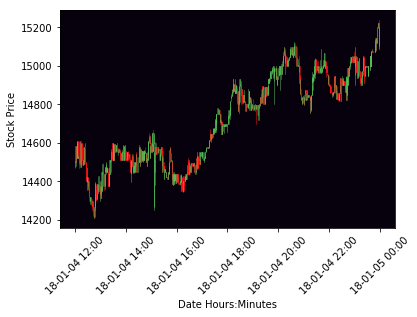

In [5]:
# Plot the stock prices for the last day
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

plot_last_n_minutes = 60 * 12  # 1/2 day
cs_frame = df.iloc[-1 * plot_last_n_minutes:].copy()  # Create the candlestick frame

#if necessary convert to datetime
cs_frame.timestamp = pd.to_datetime(cs_frame.timestamp)

cs_frame = cs_frame[['timestamp', 'open', 'high', 'low', 'close', 'volume']]
cs_frame["timestamp"] = cs_frame["timestamp"].apply(mdates.date2num)

f1 = plt.subplot2grid((6, 1), (0, 0), rowspan=6, colspan=1, axisbg='#07000d')
candlestick_ohlc(f1, cs_frame.values, width=.0001, colorup='#53c156', colordown='#ff1717', alpha=.75)
f1.xaxis_date()
f1.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))

plt.xticks(rotation=45)
plt.ylabel('Stock Price')
plt.xlabel('Date Hours:Minutes')
plt.show()

# Cleanup memory
%reset_selective -f "^cs_frame$"

In [6]:
# Add a minute moving average over period
def add_moving_avg(df, period=30):
    df[f"{period}_ma"] = pd.rolling_mean(df['close'], period)

In [7]:
add_moving_avg(df)
df.tail()

/home/rlarson/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,center=False).mean()
  This is separate from the ipykernel package so we can avoid doing imports until


,timestamp,open,high,low,close,volume,30_ma
532493,2018-01-04 23:55:00,15199.000000,15200.00000,15199.000000,15199.000000,10.446506,15063.411186
532494,2018-01-04 23:56:00,15199.000000,15220.00000,15195.582639,15220.000000,5.457758,15070.777853
532495,2018-01-04 23:57:00,15220.000000,15238.00000,15200.000000,15201.000000,7.473745,15077.644520
532496,2018-01-04 23:58:00,15200.000000,15202.21529,15085.001000,15101.591266,7.258691,15081.030929
532497,2018-01-04 23:59:00,15101.591266,15199.00000,15085.001000,15199.000000,1.777752,15087.697595
